In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import ishermitian
np.set_printoptions(linewidth=np.inf, precision=2)

In [7]:
def e_n(n, d):
    # Creates a d-dimensional vector with 1 at the n-th position and 0 elsewhere
    vec = np.zeros(d)
    vec[n%d] = 1
    return vec

def add_conj(mat):
    return mat + mat.conj().T


In [8]:
N_sub = 4 #number of sublattice sites

def H0(phi, N_cells):
    N_tot_sites = N_cells*N_sub
    H0 = np.zeros((N_cells*N_sub, N_cells*N_sub),dtype="complex128")
    for cell_idx in range(N_cells):
        zero_idx = cell_idx*N_sub
        #intracell
        H0[zero_idx, zero_idx + 1] =  np.exp(-1j*phi/2)
        H0[zero_idx, zero_idx + 2] = 1
        H0[zero_idx, zero_idx + 3] = np.exp(1j*phi/2)

        #intercell
        H0[(zero_idx+N_sub)%N_tot_sites, zero_idx + 1] = np.exp(1j*phi/2)
        H0[(zero_idx+N_sub)%N_tot_sites, zero_idx + 2] = 1
        H0[(zero_idx+N_sub)%N_tot_sites, zero_idx + 3] = np.exp(-1j*phi/2)

    return add_conj(H0)

def H(phi, U, N_cells):
    N_tot_sites = N_cells*N_sub
    h0 = H0(phi,N_cells)
    H_kin = np.kron(h0, np.eye(N_tot_sites)) + np.kron(np.eye(N_tot_sites),h0)
    diag_mask   = np.equal.outer(np.arange(N_tot_sites),
                                 np.arange(N_tot_sites)).ravel()    # True where i==j
    Hint_diag   = U * np.diag(diag_mask)
    return H_kin+Hint_diag

def shift_mat(N_cells):
    N_tot_sites = N_cells*N_sub
    R0 = np.zeros((N_cells*N_sub, N_cells*N_sub),dtype="complex128")
    for cell_idx in range(N_cells):
        zero_idx = cell_idx*N_sub
        for sub in range(N_sub):
            R0[(zero_idx + sub)%N_tot_sites, (zero_idx + sub+N_sub)%N_tot_sites] = R0[(zero_idx + sub+N_sub)%N_tot_sites,(zero_idx + sub)%N_tot_sites] = 1
    return R0

def T1(N_sites):
    return np.roll(np.eye(N_sites), shift=N_sub, axis=1)

def rot_sym(N_cells):
    N_tot_sites = N_cells*N_sub
    r0 = shift_mat(N_cells)
    return np.kron(T1(N_tot_sites), T1(N_tot_sites)) #
    #return np.kron(T1(N_tot_sites), np.eye(N_tot_sites)) + np.kron(np.eye(N_tot_sites),T1(N_tot_sites)) 
    
def fermi_penalty(N_cells):
    N_tot_sites = N_cells*N_sub
    dim = N_tot_sites**2

    mat = np.zeros((dim, dim),dtype="complex128")
    for n in range (dim):
        for m in range (dim):
            psi = np.kron( e_n(n,N_tot_sites) , e_n(m,N_tot_sites)) - np.kron( e_n(m,N_tot_sites) , e_n(n,N_tot_sites))
            mat -= np.outer(psi,psi)
    return mat


def chain(phi,U,N_cells, gamma1=1,gamma2=1):
    return H(phi,U,N_cells)+ gamma1*rot_sym(N_cells) + gamma2*fermi_penalty(N_cells) 

In [16]:
H0(0,2)

array([[0.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 0.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 0.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [9]:
ishermitian(H0(np.pi,2))

True

In [17]:
N_cells = 5
phi=2*np.pi/3
U = -10
gamma2 = 1


chain_mat = H(phi,U,N_cells)+ rot_sym(N_cells) + gamma2*fermi_penalty(N_cells) 

In [18]:
vals, vecs = np.linalg.eig(chain_mat)
mask = np.real(vals) >= -20
filt_vals = vals[mask]
filt_vecs = vecs[:, mask]  # columns are eigenvectors

phases = np.array( [np.round(filt_vecs[:,i].conj().T@rot_sym(N_cells) @ filt_vecs[:,i],decimals=8) for i in range(len(filt_vals))])
energies = np.real(filt_vals - phases)

sorted_angle = np.round(np.sort(np.angle(phases)),decimals=3)
sorted_energies = [energy for _, energy in sorted(zip(np.angle(phases), energies))]

bins = np.count_nonzero(sorted_angle == sorted_angle[0])

Ks, Kidx, K_num = np.unique(sorted_angle, return_index=True, return_counts=True)

K_energy_mesh = np.zeros( (len(Ks), np.max(K_num)))

for idx, kidx in enumerate(Kidx):
    K_energy_mesh[idx] = np.round(np.sort(sorted_energies[kidx:kidx+K_num[idx]]),decimals=3)


Text(0.5, 1.0, 'U = -10, $\\phi = 0$')

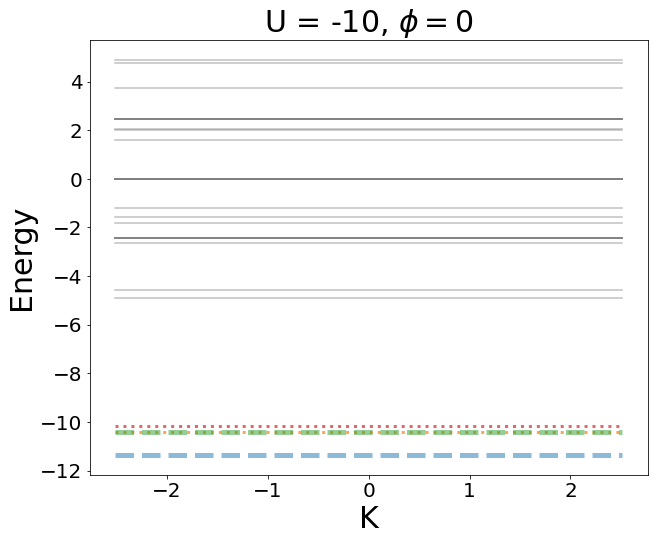

In [39]:
fs = 30

plt.figure(figsize=(10, 8))

for idx, band in enumerate(K_energy_mesh.T):
    if(idx <  4):
        if(idx%2==0):
            plt.plot(Ks,band,lw=5,alpha=.5,linestyle="--")
        else:
            plt.plot(Ks,band,lw=3,alpha=.7,linestyle=":")
    else:
        plt.plot(Ks,band,alpha=.5,color="grey")

plt.xlabel("K",fontsize = fs)
plt.ylabel("Energy",fontsize = fs)
plt.xticks(fontsize=fs-10) 
plt.yticks(fontsize=fs-10)
plt.title(r"U = -10, $\phi = 0$",fontsize=fs)


In [33]:
K_energy_mesh.T[3]

array([-10.17, -10.17, -10.17, -10.17, -10.17])

In [297]:
N_cells = 7
phi=0
U = -10
gamma2 = 1


chain_mat = H(phi,U,N_cells)+ rot_sym(N_cells) + gamma2*fermi_penalty(N_cells) 

In [298]:
vals, vecs = np.linalg.eig(chain_mat)
mask = np.real(vals) >= -20
filt_vals = vals[mask]
filt_vecs = vecs[:, mask]  # columns are eigenvectors

phases = np.array( [np.round(filt_vecs[:,i].conj().T@rot_sym(N_cells) @ filt_vecs[:,i],decimals=8) for i in range(len(filt_vals))])
energies = np.real(filt_vals - phases)

sorted_angle = np.round(np.sort(np.angle(phases)),decimals=3)
sorted_energies = [energy for _, energy in sorted(zip(np.angle(phases), energies))]

bins = np.count_nonzero(sorted_angle == sorted_angle[0])

Ks, Kidx, K_num = np.unique(sorted_angle, return_index=True, return_counts=True)

K_energy_mesh = np.zeros( (len(Ks), np.max(K_num)))

for idx, kidx in enumerate(Kidx):
    K_energy_mesh[idx] = np.round(np.sort(sorted_energies[kidx:kidx+K_num[idx]]),decimals=3)


Text(0.5, 1.0, 'U = 3, $\\phi = 0$')

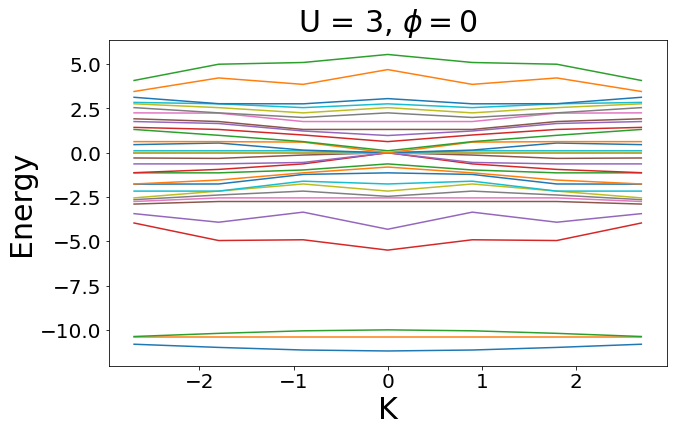

In [299]:
fs = 30

plt.figure(figsize=(10, 6))

for band in K_energy_mesh.T:
    plt.plot(Ks,band)

plt.xlabel("K",fontsize = fs)
plt.ylabel("Energy",fontsize = fs)
plt.xticks(fontsize=fs-10) 
plt.yticks(fontsize=fs-10)
plt.title(r"U = 3, $\phi = 0$",fontsize=fs)
